## imports

In [1]:
import architectures as ar
import torch
from torch import nn

## model architecture tests

In [2]:
args = []
dilations = [2,4,8,8,4]
strides=[5,4,3,2,2]
kernels=[10,8,4,4,4]
encode_dim=32


In [3]:
vicreg = ar.VicRegWaves(args,dilations,strides,kernels,encode_dim,[32,64,128,64,32])

In [4]:
bsz = 128
a1 = [torch.normal(torch.sin(torch.linspace(0,2*torch.pi,441)),torch.tensor([1])) for _ in range(bsz)]
a1 = torch.stack(a1,axis=0)[:,None,:]
print(a1.shape)

torch.Size([128, 1, 441])


In [5]:
def ProjectorTest(sizes):

    layers = []
    for ii in range(len(sizes) - 2):

        layers.append(nn.Linear(sizes[ii],sizes[ii+1]))
        layers.append(nn.BatchNorm1d(sizes[ii+1]))
        layers.append(nn.ReLU(True))
    layers.append(nn.Linear(sizes[-2],sizes[-1],bias=False))
    return nn.Sequential(*layers),layers

In [6]:
senc = vicreg.encoder.strided_encoder
denc = vicreg.encoder.dilated_encoder
proj = vicreg.projector
#sizes = vicreg.sizes
projTest,layers = ProjectorTest([32,64,128,64,32])

In [11]:
d1 = denc(a1)
s1 = senc(a1)
e1 = vicreg.encoder(a1)
ps = [e1]
for ii,layer in enumerate(layers):
    try:
        ps.append(layer(ps[ii]))
    except:
        print(f"failed on layer {ii+1}: input shape {ps[ii].shape}")
        layer(ps[ii])

loss = vicreg(a1[:64,:],a1[:64,:])

In [12]:
print(d1.shape,s1.shape,e1.shape,ps[-1].shape)

torch.Size([128, 16, 1]) torch.Size([128, 16, 1]) torch.Size([128, 32]) torch.Size([128, 32])


## dataset tests

In [1]:
import os
import glob 
import data as dt
import numpy as np

path = '/home/miles/mooney_server/Miles/fromComputer/birds_jq/CAGbirds/org545/data'
days = glob.glob(os.path.join(path,'[0-9]*'))
audio = [glob.glob(os.path.join(d,'denoised','*.wav')) for d in days]
rois = [glob.glob(os.path.join(d,'denoised_segments_syll','*.txt')) for d in days]
audio = sum(audio,[])
rois = sum(rois,[])

In [2]:
ds1 = dt.waveformSet(audio,rois,maxSegs=50,seed=100)


Pre-processing audio: 0it [00:00, ?it/s]

/home/miles/mooney_server/Miles/fromComputer/birds_jq/CAGbirds/org545/data/20220301/denoised_segments_syll/recording_20220301_131747nrd.txt


Pre-processing audio: 0it [00:00, ?it/s]


max number of segments reached!
Getting positive pair indices


being inefficient: 516it [00:18, 27.24it/s]


In [21]:
x1,x2 = ds1[6]
x1n,x2n = x1.detach().cpu().numpy(), x2.detach().cpu().numpy()

In [22]:
from scipy.signal import stft

f1,t1,sxx1 = stft(x1n,fs=ds1.fs)
f2,t2,sxx2 = stft(x2n,fs=ds1.fs)
print(sxx1.shape)
print(sxx2.shape)

(129, 5)
(129, 5)


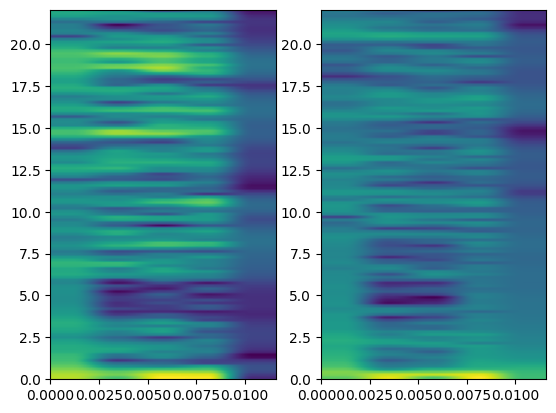

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
sxx1p = np.log(np.abs(sxx1))
sxx2p = np.log(np.abs(sxx2))
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
#print(f1)
ax1.imshow(sxx1p,origin='lower',extent=[t1[0],t1[-1],f1[0]/1e3,f1[-1]/1e3],aspect='auto')
ax2.imshow(sxx2p,origin='lower',extent=[t2[0],t2[-1],f2[0]/1e3,f2[-1]/1e3],aspect='auto')

plt.show()
plt.close()

## testing model and loader

In [28]:
import os
import glob 
import data as dt
import numpy as np
from torch.utils.data import DataLoader

#### Load data #####
path = '/home/miles/mooney_server/Miles/fromComputer/birds_jq/CAGbirds/org545/data'
days = glob.glob(os.path.join(path,'[0-9]*'))
audio = [glob.glob(os.path.join(d,'denoised','*.wav')) for d in days]
rois = [glob.glob(os.path.join(d,'denoised_segments_syll','*.txt')) for d in days]
audio = sum(audio,[])
rois = sum(rois,[])

ds1 = dt.waveformSet(audio,rois,maxSegs=50,seed=100)
dl1 = DataLoader(ds1,batch_size=64,shuffle=True,num_workers = os.cpu_count()//3)


Pre-processing audio: 0it [00:00, ?it/s]

/home/miles/mooney_server/Miles/fromComputer/birds_jq/CAGbirds/org545/data/20220301/denoised_segments_syll/recording_20220301_131747nrd.txt


Pre-processing audio: 0it [00:00, ?it/s]


max number of segments reached!
Getting positive pair indices


being inefficient: 516it [00:19, 26.47it/s]


In [33]:
import architectures as ar
#### Create model ####
args = []
dilations = [2,4,8,8,4]
strides=[5,4,3,2,2]
kernels=[10,8,4,4,4]
encode_dim=32

vicreg = ar.VicRegWaves(args,dilations,strides,kernels,encode_dim,[32,64,128,64,32])
senc = vicreg.encoder.strided_encoder
denc = vicreg.encoder.dilated_encoder
proj = vicreg.projector

In [38]:
for batch in dl1:

    x1,x2 = batch
    x1,x2 = x1[:,None,:],x2[:,None,:] # reshape to B x C x L
    print(x1.shape,x2.shape)
    d1,d2 = denc(x1),denc(x2)
    s1,s2 = senc(x1),senc(x2)
    e1,e2 = vicreg.encoder(x1),vicreg.encoder(x2)
    
    loss = vicreg(x1,x2)
    print(loss.shape)
    print(loss)
    assert False


torch.Size([64, 1, 441]) torch.Size([64, 1, 441])
torch.Size([])
tensor(16.5048, grad_fn=<AddBackward0>)


AssertionError: 

In [36]:
print(denc)

Sequential(
  (0): Conv1d(1, 16, kernel_size=(10,), stride=(3,), padding=(2,), dilation=(2,), bias=False)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Conv1d(16, 16, kernel_size=(8,), stride=(3,), padding=(4,), dilation=(4,), bias=False)
  (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv1d(16, 16, kernel_size=(4,), stride=(2,), padding=(8,), dilation=(8,), bias=False)
  (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv1d(16, 16, kernel_size=(4,), stride=(2,), padding=(8,), dilation=(8,), bias=False)
  (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv1d(16, 16, kernel_size=(4,), stride=(3,), padding=(4,), dilation=(4,), bias=False)
  (9): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
